In [48]:
# Imports

import numpy as np
import pandas
import os, os.path
from itertools import *
%matplotlib inline
import matplotlib.pyplot as plt

# Idempotent data retrieval script

chromosomes = [1, 2, 6, 7, 11]
def chromosome_files(n):
    base = 'intersected_final_chr'
    spec = '_cutoff_20_'
    suffixes = ['train.bed', 'sample_partial.bed', 'sample_full.bed']
    return [base + str(n) + spec + suffix for suffix in suffixes]
all_files = set(chain.from_iterable(chromosome_files(n) for n in chromosomes))

if 'methylation_imputation' not in [x for x in os.listdir('.') if os.path.isdir(x)]:
    raise Exception('Missing assignment repository in cwd')

if not os.path.exists('data'):
    os.mkdir('data')

def all_files_present(): return all_files.issubset(set(os.listdir('data')))
if not all_files_present():
    ! gunzip -k methylation_imputation/data/*.bed.gz
    ! mv methylation_imputation/data/*.bed data/
    if not all_files_present():
        raise Exception('Error unpacking data')

def read_tsv(name): return pandas.read_csv(name, sep='\t', header=None)
train_chr1 = read_tsv('data/' + chromosome_files(1)[0])
test_chr1_partial = read_tsv('data/' + chromosome_files(1)[1])
test_chr1_full = read_tsv('data/' + chromosome_files(1)[2])

SITE_START = 1
SITE_END = 2
STRAND_TYPE = 3
TRAIN_COLS = list(range(4, train_chr1.shape[1] - 4))
TEST_COL = 4
unknown_chr1_ix = np.where(test_chr1_partial[5] == 0)[0]

In [29]:
train_chr1.loc[range(267, 273)]

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
267,chr1,121511,121513,+,0.714286,0.739130,0.800000,0.782609,0.794872,0.750000,...,0.860465,0.789474,NaN,0.727273,0.896552,0.810811,0.809524,0.842105,0.880000,0
268,chr1,121516,121518,+,0.857143,0.800000,0.833333,0.913043,0.909091,0.806452,...,0.931818,0.888889,NaN,0.840000,0.862069,0.756757,0.916667,0.833333,0.916667,0
269,chr1,122736,122738,-,0.545455,0.384615,0.472727,NaN,0.436364,0.580000,...,0.487179,NaN,NaN,NaN,0.413043,0.462963,0.533333,0.659574,0.682927,0
270,chr1,122869,122871,-,0.837838,0.814815,0.725000,0.807692,0.710526,0.565217,...,0.629630,NaN,NaN,NaN,0.755556,0.590909,0.681818,0.657143,NaN,0
271,chr1,122884,122886,-,0.842105,0.821429,0.720930,0.800000,0.795455,0.478261,...,0.617021,NaN,NaN,NaN,0.682927,0.562500,0.739130,0.666667,0.756098,0
272,chr1,127749,127751,+,0.633333,0.473684,0.703704,0.611111,0.827586,0.666667,...,0.782609,0.800000,NaN,0.812500,0.500000,0.812500,0.840909,0.687500,0.807692,0


In [62]:
assert len(train_chr1) == len(test_chr1_partial) and len(train_chr1) == len(test_chr1_full)
def count_unique(col):
    return {x:sum(col == x) for x in set(col)}

print('Chromosome 1')
print('Total samples', len(train_chr1))
print('Site lengths', count_unique(train_chr1[SITE_END] - train_chr1[SITE_START]))
print('Strand types', count_unique(train_chr1[STRAND_TYPE]))
print('Unknown sample site counts', len(unknown_chr1_ix))
methyl_train_chr1 = train_chr1[TRAIN_COLS].values
methyl_test_chr1 = test_chr1_partial[TEST_COL].values
print('NaN ratio in all train samples', sum(sum(np.isnan(methyl_train_chr1))) / methyl_train_chr1.size)
print('NaN ratio in test', sum(np.isnan(methyl_test_chr1)) / methyl_test_chr1.size)

Chromosome 1
Total samples 379551
Site lengths {2: 379551}
Strand types {'-': 1464, '+': 378087}
Unknown sample site counts 371941
NaN ratio in all train samples 0.0928976606569
NaN ratio in test 0.980179211753


In [84]:
known_chr1_ix = np.where(test_chr1_partial[5] == 1)[0]
print('in-sample nans', sum(np.isnan(methyl_test_chr1[known_chr1_ix])))
known_chr1_ix = np.where(np.logical_and(test_chr1_partial[5] == 1,
                                        np.logical_not(np.isnan(methyl_test_chr1))))[0]

in-sample nans 87


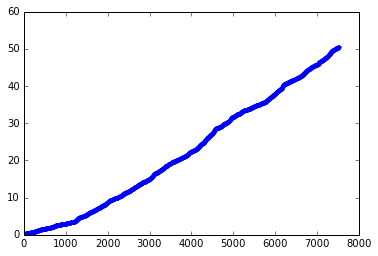

avg length between known sites 50.2903483116


In [87]:
# Make sure our samples are pretty uniform from the genomic range
plt.plot(known_chr1_ix / len(known_chr1_ix), '.')
plt.show()
print('avg length between known sites', np.mean(np.diff(known_chr1_ix))) # CDF